# Resizing time dimensions

**FLIMngo requires all input data to have 256 time dimensions.** <br>
While we strongly encourage using data with 256 time dimensions when possible, here we provide an example of how time dimensions can be resized.<br>
This is demonstrated using a simulated image with `128 time dimensions` and `0.0977 bin width`. 

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

current_folder = globals()['_dh'][0]
print(current_folder)
os.chdir(os.path.join(current_folder, '..'))

from utils.eval_utils import load_tiff, normalise, visualise_images, resize_data_tdim, resize_time

from backbone.flimngo_net import GetModel

C:\Users\User\Desktop\PhD\Projects\dl_flim\FLIMngo\demo_notebooks


In [2]:
# load cuda if available, if not choose cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preprocessing

- Load raw data from `.tiff` files with dimensions `(x, y, t)`.
- **Normalise** the time dimension to a range between 0 and 1.
- The **background has already** been masked during data simlation.

In [3]:
dir_data = 'sample_data/time_dimensions_128'

In [4]:
os.listdir(dir_data)

['gt_sample_nTG_128_bw_0.0977.tiff', 'sample_nTG_128_bw_0.0977.tiff']

In [5]:
data_id = 'sample_nTG_128_bw_0.0977.tiff'
original_bin_width = 0.0977

# laod the .tif files containing the data with the "standard" and "reduced" photon counts
raw_data = load_tiff(dir=dir_data, filename=data_id)
normalised_data = normalise(data=raw_data)

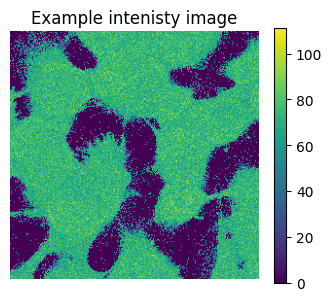

In [6]:
# visualise example intenisty image
# this will ensure that images have been correctly loaded
plt.figure(figsize=(4, 3.3))  # set the figure size
plt.imshow(raw_data.sum(0))  # display the summed image (i.e. intensity)
plt.title("Example intenisty image")
plt.colorbar() 
plt.axis('off')
plt.show()

## Predict Data
Please note: **resizing the time dimentions will change the ``bin width`` of the data**.<br>
Please indicate the **resized** bin width to the model

In [7]:
# resize time dimention of data, target time dimention should always be 256
data_resized = resize_data_tdim(data=normalised_data, time_dim_target=256)

# get new bin width
time_dim_resized =resize_time(data=normalised_data, bin_width=original_bin_width)
bin_width_resized = time_dim_resized[1]-time_dim_resized[0]
print(f"new bin width = {bin_width_resized} ns")


new bin width = 0.048658431372549014 ns


In [8]:
model_id ='flimngo_pretrained_v13102024.pth' # model id

In [9]:
image_size = 256  # x, y dimensions

class Options:
    def __init__(self):
        self.model = 'flimngo'
        self.cpu = not torch.cuda.is_available()  
        self.imageSize = image_size  # image size (x, y)
        self.n_in_channels = 256  # number of time channels
        self.width_multiple = 0.5
        self.bin_width = bin_width_resized  # replace with bin width after data resizing
        
# create an instance of the options
opt = Options()
model = GetModel(opt).to(device=device)

In [10]:
# load the model
model.load_state_dict(torch.load(model_id, map_location=device))
model.eval()


# convert resized data to pytoch tensor
data_tensor = torch.tensor(data_resized, dtype=torch.float32).unsqueeze(0).to(device)

# predict lifetime values
with torch.no_grad():
    predicted_ar = model(data_tensor).cpu().numpy()

## Data Evaluation

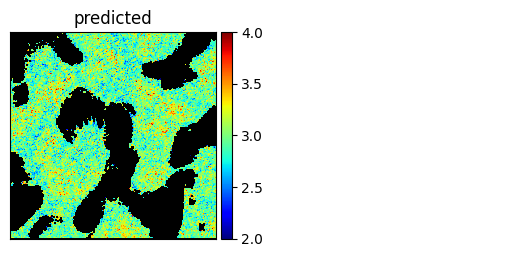

In [11]:
# visualise images
vmin, vmax = 2, 4
visualise_images([predicted_ar], ['predicted'], cmap_c='jet', vmin=vmin, vmax=vmax, columns = 2)


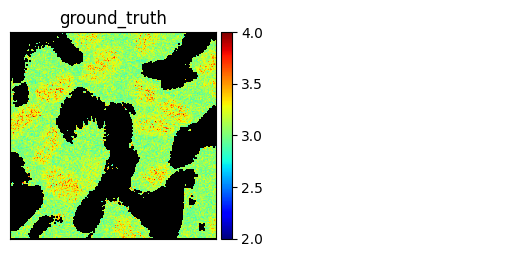

In [12]:
# load ground truth data for comparison
gt_id = 'gt_sample_nTG_128_bw_0.0977.tiff'
ground_truth =  load_tiff(dir=dir_data, filename=gt_id)

visualise_images([ground_truth], ['ground_truth'], cmap_c='jet', vmin=vmin, vmax=vmax, columns = 2)

In [13]:
# calculate mse score between predicted and ground truth
predicted = np.nan_to_num(predicted_ar.flatten(), nan=0.0)
ground_truth = np.nan_to_num(ground_truth.flatten(), nan=0.0)
mse = mean_squared_error(ground_truth, predicted)

print(f'mse between predicted and ground truth :{mse:.3f}')

mse between predicted and ground truth :0.091
